##  **Implementation of LSTM to predict the pollution levels**

### 1. Importing Libraries

In [ ]:
#For data loading and Plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For data preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# For LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# For model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### 2. Load the Data

In [18]:
# Load the dataset
df = pd.read_csv("pollution.csv")

In [19]:
# Rename columns to make them easier to understand
df = df.rename(columns={
    'pm2.5': 'pollution',
    'DEWP': 'dew_point',
    'TEMP': 'temperature',
    'PRES': 'pressure',
    'cbwd': 'wind_direction',
    'Iws': 'wind_speed',
    'Is': 'snow',
    'Ir': 'rain'
})

# Display the first few rows of the dataset
df.head()

,No,year,month,day,hour,pollution,dew_point,temperature,pressure,wind_direction,wind_speed,snow,rain
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### 3. Set Timestamp Index and Drop Unnecessary Columns

In [20]:
# Set the index to the timestamp using year, month, day, and hour columns
df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Drop unnecessary columns
df = df.drop(columns=['No', 'year', 'month', 'day', 'hour'])

# Display the updated dataset to confirm changes
df.head()

,pollution,dew_point,temperature,pressure,wind_direction,wind_speed,snow,rain
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### 4. Handle Missing Values and Encode Categorical Data

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pollution       41757 non-null  float64
 1   dew_point       43824 non-null  int64  
 2   temperature     43824 non-null  float64
 3   pressure        43824 non-null  float64
 4   wind_direction  43824 non-null  object 
 5   wind_speed      43824 non-null  float64
 6   snow            43824 non-null  int64  
 7   rain            43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [24]:
df.isnull().sum()

pollution         2067
dew_point            0
temperature          0
pressure             0
wind_direction       0
wind_speed           0
snow                 0
rain                 0
dtype: int64

In [25]:
# Forward-fill missing pollution data and drop rows if NaN values remain
df['pollution'].fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

C:\Users\Hp\AppData\Local\Temp\ipykernel_6888\4197802556.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['pollution'].fillna(method='ffill', inplace=True)


In [26]:
# Encode the categorical `wind_direction` column using LabelEncoder
label_encoder = LabelEncoder()
df['wind_direction_encoded'] = label_encoder.fit_transform(df['wind_direction'])

# Drop the original `wind_direction` column after encoding
df.drop('wind_direction', axis=1, inplace=True)

# Display the updated dataset
df.head()

,pollution,dew_point,temperature,pressure,wind_speed,snow,rain,wind_direction_encoded
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,2
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,2
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,2
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,2
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,2


### 5. Visualize Trends and Relationships

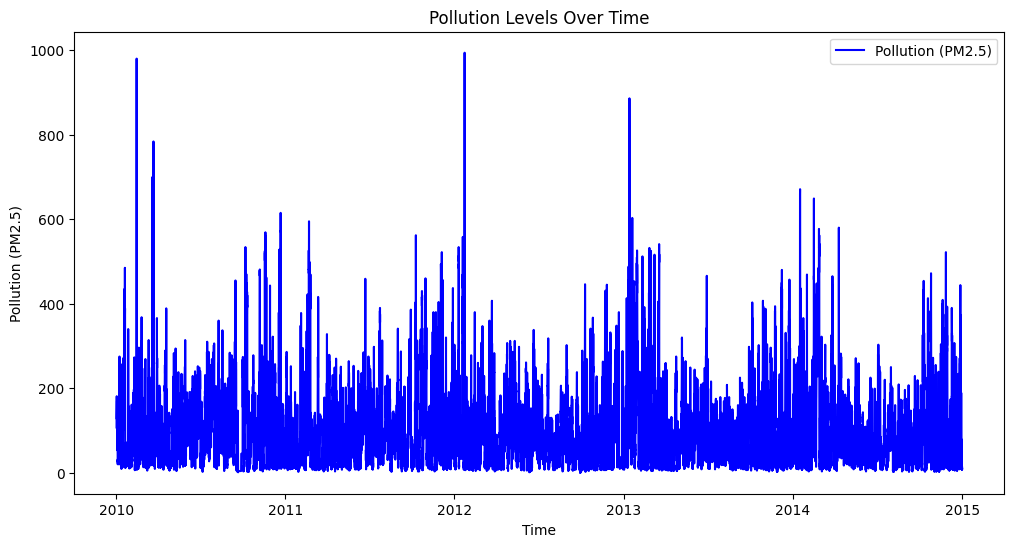

In [27]:
# Pollution Trend Over Time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['pollution'], label="Pollution (PM2.5)", color="blue")
plt.title("Pollution Levels Over Time")
plt.xlabel("Time")
plt.ylabel("Pollution (PM2.5)")
plt.legend()
plt.show()

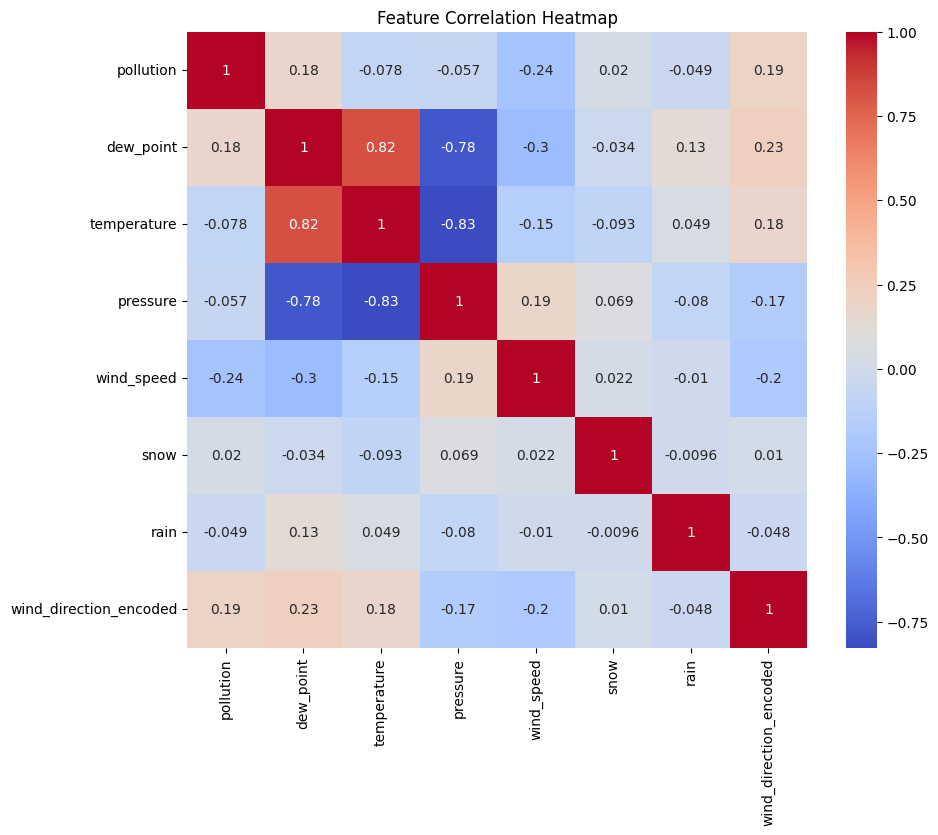

In [28]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

### 6. Prepare Data for Model Training

In [29]:
# Feature Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)  # Scale all columns to [0, 1] range

In [30]:
# Create Time-Series Features for LSTM
lookback = 24  # Define lookback period (e.g., last 24 hours)
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])  # Use the previous `lookback` hours as features
    y.append(scaled_data[i, 0])  # Target is `pollution` (1st column in scaled data)
X, y = np.array(X), np.array(y)

In [32]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print("Data Preparation Completed!")

Shape of X_train: (35020, 24, 8)
Shape of y_train: (35020,)
Data Preparation Completed!


### 7. Build and Train the LSTM Model

In [40]:
# Define the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)  # Output layer for predicting pollution
])

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training if val_loss doesn't improve for 3 consecutive epochs
    restore_best_weights=True  # Restore the weights of the best epoch
)

In [45]:
# Train the Model
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=64, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping],  # Add EarlyStopping here
    verbose=1)

print("Model Training Completed!")

Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - loss: 8.7523e-04 - val_loss: 7.4676e-04
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 5.9719e-04 - val_loss: 5.4539e-04
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 5.6353e-04 - val_loss: 5.6505e-04
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - loss: 5.5494e-04 - val_loss: 5.5080e-04
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 4.9350e-04 - val_loss: 5.4073e-04
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - loss: 5.3291e-04 - val_loss: 5.4220e-04
Epoch 8/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 5.1885e-04 - val_loss: 5.3256e-04
Epoch 9/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - loss: 6.0068e-04 - val_loss: 5.5419e-04
Epoch 10/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 5.3682e-04 - val_loss: 5.3338e-04
Epoch 11/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 20s 36

### 8. Evaluate the Model

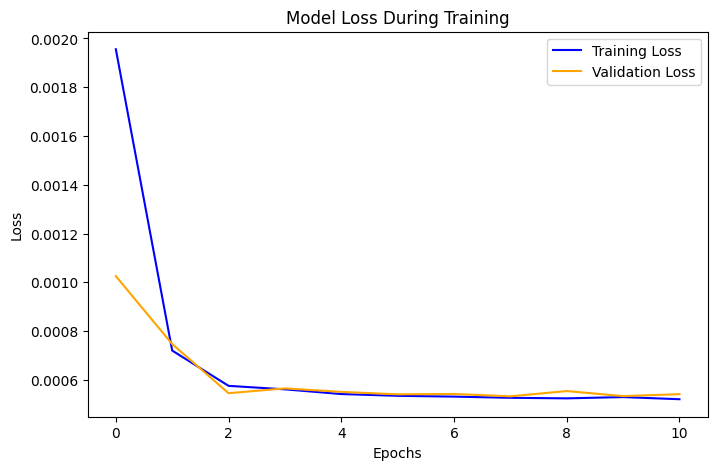

274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 5.8476e-04
Test Loss: 0.0005


In [46]:
# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on Test Data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")


### 9. Save the Model

In [47]:
# Save the trained model
model.save("air_quality_forecasting_model.h5")
print("Model Saved Successfully!")


Model Saved Successfully!


### 10. Make Predictions

274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step


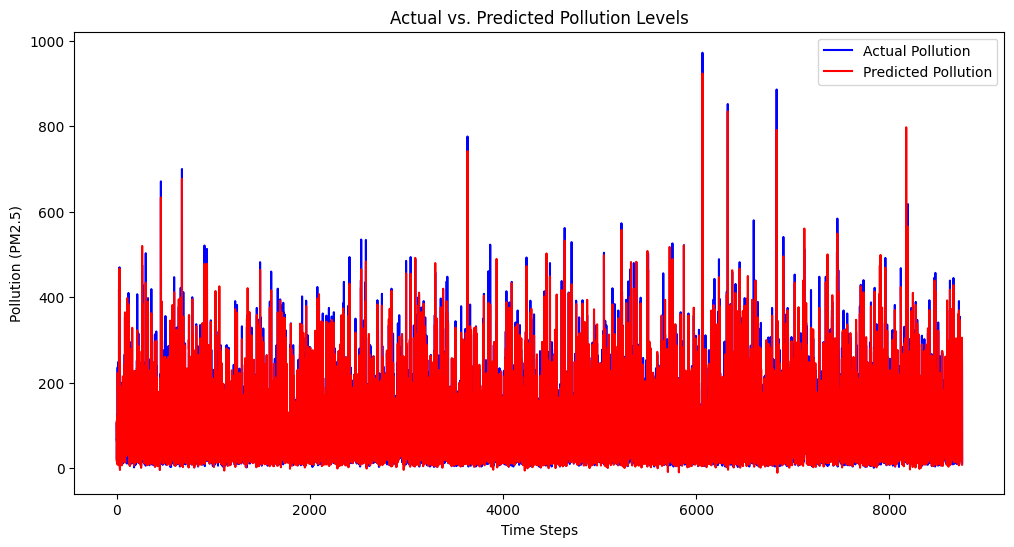

In [48]:
# Make Predictions on Test Data
predictions = model.predict(X_test)

# Rescale Predictions and True Values for Comparison
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), df.shape[1] - 1))), axis=1))[:, 0]
predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), df.shape[1] - 1))), axis=1))[:, 0]

# Plot Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Pollution", color="blue")
plt.plot(predictions_rescaled, label="Predicted Pollution", color="red")
plt.title("Actual vs. Predicted Pollution Levels")
plt.xlabel("Time Steps")
plt.ylabel("Pollution (PM2.5)")
plt.legend()
plt.show()
